## m

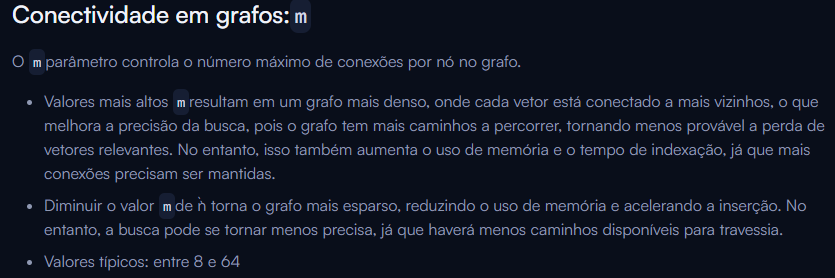

In [ ]:
from qdrant_client.models import HnswConfig

# Example m values
fast_config = HnswConfig(m=8, ef_construct=100, full_scan_threshold=10000)      # Lower recall, less memory, faster build
balanced_config = HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000) # Default - good balance
accurate_config = HnswConfig(m=32, ef_construct=100, full_scan_threshold=10000) # Better recall, more memory, slower build

## ef_construct

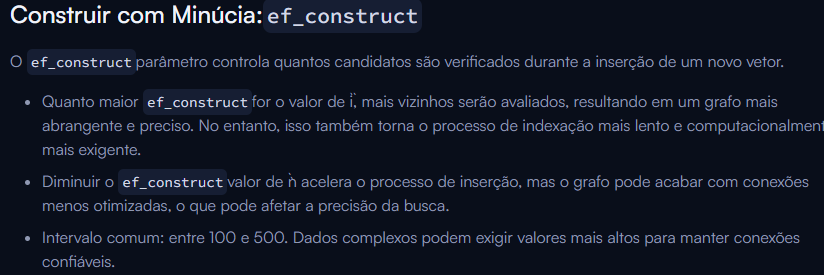

In [ ]:
# Example ef_construct values
fast_build = HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000)      # Default - Faster indexing, lower quality
balanced_build = HnswConfig(m=16, ef_construct=200, full_scan_threshold=10000)  # Good balance
quality_build = HnswConfig(m=16, ef_construct=400, full_scan_threshold=10000)   # Slower indexing, higher quality

## hnsw_ef

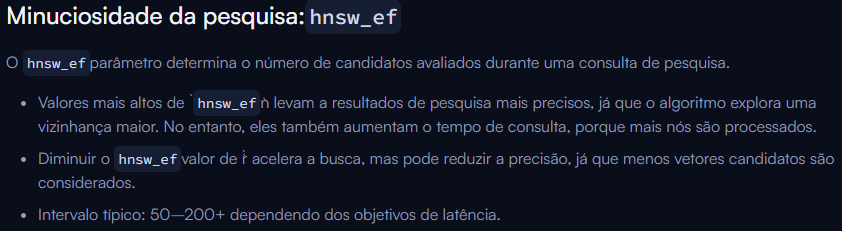

In [ ]:
from qdrant_client.models import SearchParams

# hnsw_ef is set at search time, not build time
fast_search = SearchParams(hnsw_ef=32)      # Very fast, lower recall
balanced_search = SearchParams(hnsw_ef=128) # Default - good balance
accurate_search = SearchParams(hnsw_ef=256) # Higher recall, slower

## Resumo

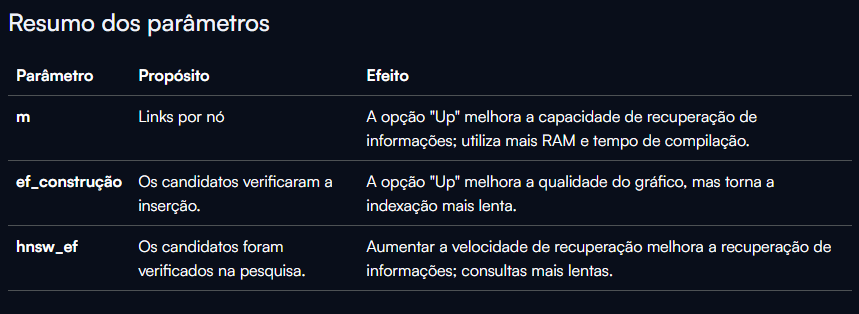

## Otimizando para diferentes cargas de trabalho

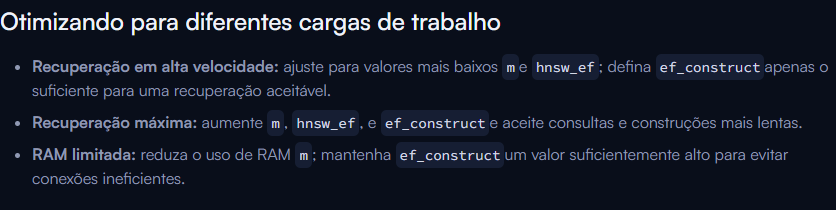

## Exemplos de configuração prática

In [1]:
from qdrant_client import QdrantClient, models
from materials.q_drant_client import client

client.create_collection(
    collection_name="production_vectors",
    vectors_config=models.VectorParams(
        size=768,
        distance=models.Distance.COSINE,
        hnsw_config=models.HnswConfigDiff(
            m=16,  # Balanced connections (default)
            ef_construct=200,  # Good build quality (default)
            full_scan_threshold=10000,  # Use brute force below this size (default)
        ),
    ),
)

# Development / testing: faster builds
client.create_collection(
    collection_name="dev_vectors",
    vectors_config=models.VectorParams(
        size=384,
        distance=models.Distance.COSINE,
        hnsw_config=models.HnswConfigDiff(
            m=8,  # Fewer connections
            ef_construct=100,  # Faster builds
            full_scan_threshold=10000,  # Use brute force below this size (default)
        ),
    ),
)


collections=[CollectionDescription(name='day0_first_system'), CollectionDescription(name='my_first_collection')]


True

## Análise comparativa de desempenho

### Full Scan Threshold

O parâmetro full_scan_threshold no Qdrant é um ajuste de performance que define o "ponto de virada" entre usar a busca por aproximação (HNSW) ou uma busca exata (Brute Force).

Aqui está a explicação detalhada:

1. O que ele faz?
Ele determina a quantidade mínima de vetores necessária em uma coleção (ou segmento) para que o Qdrant comece a usar o índice HNSW.

Se o número de vetores for menor que esse valor, o Qdrant ignora o índice e faz uma busca linear (varredura completa/brute force).
Se for maior, ele usa a estrutura do grafo HNSW.
2. Por que isso existe? (O motivo da performance)
Para coleções muito pequenas, percorrer a estrutura complexa de um grafo (nós, camadas, conexões) é mais lento do que simplesmente comparar o seu vetor de busca com todos os outros vetores um por um.

A "matemática" da CPU funciona melhor com varreduras lineares em conjuntos pequenos de dados do que com saltos de memória aleatórios necessários para navegar em um grafo.

3. Qual o impacto neste código?
Neste exemplo:

python
full_scan_threshold=100
Isso significa que enquanto você tiver entre 1 e 100 vetores na sua coleção, o Qdrant não vai perder tempo "navegando" no HNSW; ele vai calcular a distância de todos eles instantaneamente. A partir do vetor 101, ele passará a usar a lógica do HNSW para garantir escala.

4. Diferença importante: full_scan_threshold vs indexing_threshold
Note que você também usou o indexing_threshold no seu código. Embora pareçam iguais, eles controlam momentos diferentes:

full_scan_threshold (em hnsw_config): Controla a estratégia de Busca. Diz: "Se eu tiver poucos dados, ignore o índice HNSW e faça busca linear (brute force)".
indexing_threshold (em optimizers_config): Controla o momento da Criação do Índice. Diz: "Não perca tempo construindo o grafo HNSW (que é caro computacionalmente) até que eu tenha pelo menos X vetores".

Resumo
Manter esse valor em 100 ou até 1000 é geralmente uma boa prática, pois garante que em coleções pequenas você tenha 100% de precisão (já que brute force é exato) com a máxima velocidade possível para esse volume de dados.

In [2]:
collection_name = "my_collection"

if client.collection_exists(collection_name=collection_name):
    client.delete_collection(collection_name=collection_name)


# Development / testing: faster builds
client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=4,
        distance=models.Distance.COSINE,
        hnsw_config=models.HnswConfigDiff(
            m=8,  # Fewer connections
            ef_construct=100,  # Faster builds
            full_scan_threshold=100,  # Use brute force below this size (default)
        ),
    ),
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=100,  # Use brute force below this size (default)
    ),
)

# upload data
import random

points = []
for i in range(20000):
    points.append(
        models.PointStruct(id=i, vector=[random.random() for _ in range(4)], payload={})
    )
client.upload_points(
    collection_name=collection_name,
    points=points,
)

## Desempenho da pesquisa

In [4]:
import time

def benchmark_search_performance(collection_name, test_queries, ef_values):
    """Compare latency across hnsw_ef values"""

    results = {}
    for hnsw_ef in ef_values:
        start_time = time.time()
        for query in test_queries:
            client.query_points(
                collection_name=collection_name,
                query=query,
                limit=10,
                search_params=models.SearchParams(hnsw_ef=hnsw_ef),
            )

        avg_time = (time.time() - start_time) / len(test_queries)
        results[hnsw_ef] = avg_time
        print(f"hnsw_ef={hnsw_ef}: {avg_time:.3f}s per query")

    return results


# Test different hnsw_ef values
test_queries = [
    [30, 60, 90, 120],
    [150, 180, 210, 240],
    [270, 300, 330, 360],
    [390, 420, 450, 480],
    [510, 540, 570, 600],
]

ef_values = [32, 64, 128, 256]
performance = benchmark_search_performance(collection_name, test_queries, ef_values)

hnsw_ef=32: 0.241s per query
hnsw_ef=64: 0.226s per query
hnsw_ef=128: 0.175s per query
hnsw_ef=256: 0.151s per query


## Análise de desempenho e uso de índices

In [5]:
# Inspect collection status
info = client.get_collection(collection_name)

vectors_per_point = 1  # set per your vectors_config
vectors_count = info.points_count * vectors_per_point

print(f"Collection status: {info.status}") 
print(f"Total points: {info.points_count}")
print(f"Indexed vectors: {info.indexed_vectors_count}")

if vectors_count:
    proportion_unindexed = 1 - (info.indexed_vectors_count / vectors_count)
else:
    proportion_unindexed = 0

print(f"Proportion unindexed: {proportion_unindexed:.2%}")

if info.status == models.CollectionStatus.GREEN:
    print("\n✅ Collection is indexed and ready!")
elif info.status == models.CollectionStatus.YELLOW:
    print("\n⚠️ Collection is still being indexed (optimizing).")
else:
    print(f"\n❌ Collection status is {info.status}.")

Collection status: green
Total points: 20000
Indexed vectors: 19200
Proportion unindexed: 4.00%

✅ Collection is indexed and ready!


Esse output é muito comum no Qdrant e traz informações valiosas sobre o que está acontecendo "debaixo do capô". Aqui está a análise do que esses números significam:

1. Status: green (Verde)
No Qdrant, o status Green não significa necessariamente que 100% dos vetores estão indexados no grafo HNSW. Significa que a coleção está saudável, estável e pronta para todas as operações. Os processos de otimização (indexação) não estão falhando e não há tarefas críticas pendentes que impeçam o uso.

2. O mistério dos 4%: Por que Indexed vectors (19.200) é menor que Total points (20.000)?
Este é o ponto mais importante. O Qdrant divide os dados em segmentos:

Segmentos Indexados: Onde o grafo HNSW já foi construído (os 19.200).
Buffer/Segmentos "Plain": Quando você adiciona dados novos, eles ficam em um segmento temporário que utiliza busca linear (brute force) enquanto espera para ser grande o suficiente para disparar a criação do índice HNSW (os 800 restantes, ou 4%).
Por que isso acontece? Construir um grafo HNSW é caro computacionalmente. O Qdrant não reconstrói o grafo a cada novo vetor que chega. Ele espera acumular uma certa quantidade de novos vetores (definida pelo seu indexing_threshold) para então rodar o Optimizer e fundir esses novos vetores no índice principal.

3. Impacto na sua Consulta (Search)
Você pode estar se perguntando: "Se 4% não estão indexados, minha busca vai ignorar esses 800 pontos?" A resposta é não.

O Qdrant é inteligente:

Ele faz a busca rápida via HNSW nos 19.200 pontos indexados.
Ele faz uma busca exata (Brute Force) nos 800 pontos que ainda estão no "limbo".
Ele combina os dois resultados e te entrega o Top K global.
Portanto, sua busca continua sendo 100% precisa, apenas esses 4% finais são processados de forma um pouco diferente internamente.

4. Resumo do que esperar:
Se você parar de inserir dados: Em alguns segundos ou minutos (dependendo da CPU), o processo de otimização vai terminar e o Indexed vectors chegará a 20.000.
Se você continuar inserindo dados: É normal que o Proportion unindexed flutue. Ele sobe conforme você insere e desce conforme o Qdrant termina de indexar os blocos.
Status Yellow: Se o status mudar para yellow, significa que o Qdrant está ativamente reconstruindo os índices (otimizando). Ele ainda funciona, mas está sob carga de processamento.
Conclusão: Seu resultado está excelente. Ele mostra um banco de dados operando normalmente, gerenciando o buffer de entrada de forma eficiente.

## Quando não usar HNSW

### Pequenas Coleções

Para coleções com menos de 10.000 vetores, a força bruta costuma ser mais rápida e usar menos RAM do que construir uma rede neural de alto desempenho (HNSW).

### Requisitos de pesquisa exatos

HNSW é aproximado. Se você precisa de resultados exatos, use força bruta.